- Welcome to Quantitative and High Frequency Trading Training Program


In [1]:
from helper import *
from stats import *
from imp import reload   
import helper
import stats
reload(helper)
reload(stats)
get_signal_performance_result

<function helper.get_signal_performance_result(all_period_signal, signal_dire, period, product_list, train_sample, test_sample)>

In [2]:
## parallel generate the distribution of a signal
def par_get_all_signal(signal_name, file_list, product, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", DATA_PATH="d:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S = load(HEAD_PATH+"/tmp pkl/"+product+"/"+signal_name+"/"+file) ## signal
        good = load(DATA_PATH+"/good pkl/"+product+"/"+file) ## good singal
        signal = S[good]
        #moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product+"."+signal_name+".pkl")

- number of cores, set this number according to your computer

In [3]:
CORE_NUM = int(os.environ['NUMBER_OF_PROCESSORS'])
CORE_NUM

16

- sample product, you can change to your specific product symbol

In [4]:
product_list = ["bu", "ru", "v", "pp", "l", "jd"]

In [5]:
import dask
from dask import compute, delayed

- sample period

In [6]:
period = 4096

In [7]:
all_dates = os.listdir(DATA_PATH + product_list[0])
all_dates.sort()
all_dates = np.array(all_dates)
n_days = len(all_dates)
n_days


1066

- choose an example day

In [9]:
split_date = "201910"
train_sample = all_dates<split_date
test_sample = all_dates>split_date
date_str = [n[0:8] for n in all_dates]
format_dates = np.array([pd.to_datetime(d) for d in date_str])


- Now we start our new topics:
- cross-period signal
- cross-symbol signal
- arbitrage

- First, we look at cross-period signal

- we can first generate good index of data
- because loading data each time is too time consuming

In [10]:
import os
os.makedirs(HEAD_PATH + "/good pkl", exist_ok=True)
for product in product_list:
    os.makedirs(HEAD_PATH + "/good pkl/" + product, exist_ok=True)

In [12]:
os.makedirs(HEAD_PATH+"/all signal", exist_ok=True)
dire_signal_list = ["trade.imb", "total.trade.imb", "nr", "dbook", "range.pos", "price.osci", "ma.dif.10", "kdj.k", "kdj.j"]
range_signal_list = ["", "range", "std", "volume.open.ratio", "trend.index"]
all_signal_list = np.array([])
for range_signal in range_signal_list:
    for dire_signal in dire_signal_list:
        if len(range_signal)==0:
            signal_name = dire_signal
        else:
            signal_name = dire_signal+"."+range_signal
        all_signal_list = np.append(all_signal_list,signal_name)
len(all_signal_list)
all_comb_list = [signal+".comb" for signal in all_signal_list]
all_period_signal = [signal+".4096" for signal in all_signal_list]
SAVE_PATH = "e:/intern"

- now we compare the result of comb signal and previous signal

In [13]:
product_x = "bu"
product_y = "ru"
data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+all_dates[100])
data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+all_dates[100])

In [14]:
data_x["date.time"][0:10]

0    2018-03-05 20:59:00.500
1    2018-03-05 21:00:00.500
2    2018-03-05 21:00:01.000
3    2018-03-05 21:00:01.500
4    2018-03-05 21:00:02.000
5    2018-03-05 21:00:02.500
6    2018-03-05 21:00:03.000
7    2018-03-05 21:00:03.500
8    2018-03-05 21:00:04.000
9    2018-03-05 21:00:04.500
Name: date.time, dtype: object

In [15]:
data_y["date.time"][0:10]

0    2018-03-05 20:59:00.500
1    2018-03-05 21:00:00.500
2    2018-03-05 21:00:01.000
3    2018-03-05 21:00:01.500
4    2018-03-05 21:00:02.000
5    2018-03-05 21:00:02.500
6    2018-03-05 21:00:03.000
7    2018-03-05 21:00:03.500
8    2018-03-05 21:00:04.000
9    2018-03-05 21:00:04.500
Name: date.time, dtype: object

In [16]:
os.makedirs(HEAD_PATH+"/comb time", exist_ok=True)
os.makedirs(HEAD_PATH+"/comb time/"+product_x+"_"+product_y, exist_ok=True)

In [17]:
from collections import Counter
def get_shfe_comb_pos(date, product_x, product_y, HEAD_PATH):
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+date)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+date)
    comb_time = np.intersect1d(data_x["date.time"], data_y["date.time"])
    comb_time_set = set(comb_time) ## delete duplicate times
    time_x = [element in comb_time_set for element in data_x["date.time"]] ## if in intersect then true, otherwise false
    time_y = [element in comb_time_set for element in data_y["date.time"]]
    if len(comb_time_set)!=len(time_x) or len(comb_time_set)!=len(time_y):
        count_x = Counter(data_x["date.time"])
        count_y = Counter(data_y["date.time"])
        good_x = [count_x[x]==1 and count_y[x]==1 for x in data_x["date.time"]]
        good_y = [count_x[x]==1 and count_y[x]==1 for x in data_y["date.time"]]
        time_x = (time_x and good_x)
        time_y = (time_y and good_y)
    save([time_x, time_y], HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+date)

- let's go to arbitrage

In [18]:
%%time
result = parLapply(CORE_NUM, all_dates, get_shfe_comb_pos, product_x=product_x, product_y=product_y, HEAD_PATH=HEAD_PATH)

#Wall time: 4min 19s

Wall time: 2min 11s


In [19]:
def par_get_arb_all_signal(signal_name, file_list, product_x, product_y, period, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern"):
    n_files = len(file_list)
    all_signal = np.array([])
    for file in file_list:
        S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
        S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
        [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
        signal = S_x[time_x] - S_y[time_y] ## calculate the difference of signal
        moving_average(signal,period)
        chosen = (np.arange(len(signal))+1) % period==0
        all_signal = np.concatenate((all_signal, signal[chosen]), axis=0)
    save(all_signal, SAVE_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [20]:
%%time
result = par_get_arb_all_signal("total.trade.imb.4096",  file_list=all_dates, product_x=product_x, 
                   product_y = product_y, period=4096, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH)

# Wall time: 1min 29s

Wall time: 1min 29s


In [21]:
## use signal of product_x to trade product_y
from collections import OrderedDict
def get_cross_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct=1.1e-4, max_spread=0.61, tranct_ratio=True, 
                         HEAD_PATH="d:/intern",SAVE_PATH="e:/intern",atr_filter=0, rebate=0):
    ## load data
    good_x = load(SAVE_PATH+"/good pkl/"+product_x+"/"+file)
    data = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file) ## signal from product_x
    pred = S*reverse
    pred = pred[time_x] ## use duplicate ticks
    atr = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+"atr.4096"+"/"+file)
    atr = atr[time_x].reset_index(drop=True)
    data = data[time_y].reset_index(drop=True) ## use duplicate ticks 
    atr = atr[data["good"]].reset_index(drop=True)
    pred = pred[data["good"]]
    data = data[data["good"]].reset_index(drop=True)    
    #atr = atr[time_x].reset_index(drop=True)
    #data = data[time_y].reset_index(drop=True)
    #n_bar = len(data)
    
    ## load signal
    
    ## we don't know the signal is positive correlated or negative correlated  
    #n_thre = len(thre_mat)
    count = 0;
    cur_spread = data["ask"]-data["bid"]
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)

    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        signal[atr<atr_filter]=0
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 1
        position_pos[(pred< -scratch) & (data["next.bid"]>0) & (cur_spread<max_spread)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos = pd.Series(data=0, index=data.index)
        notional_position_pos[position_pos==1] = 1
        notional_position_pos[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos[(notional_position_pos==1)] = 1/data["next.ask"][(notional_position_pos==1)]
        notional_position_pos.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data["next.ask"]>0) & (data["next.bid"]>0) & (cur_spread<max_spread)] = -1
        position_neg[(pred> scratch) & (data["next.ask"]>0) & (cur_spread<max_spread)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg = pd.Series(data=0, index=data.index)
        notional_position_neg[position_neg==-1] = -1
        notional_position_neg[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg[(notional_position_neg==-1)] = -1/data["next.bid"][(notional_position_neg==-1)]
        notional_position_neg.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position = notional_position_pos+notional_position_neg
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position.iloc[0] = 0
        notional_position.iloc[-2:] = 0
        change_pos = position - position.shift(1)
        notional_change_pos = notional_position-notional_position.shift(1)
        change_pos.iloc[0] = 0
        notional_change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data.index)
        change_buy = change_pos>0
        change_sell = change_pos<0
        if (tranct_ratio):
            change_base[change_buy] = data["next.ask"][change_buy]*(1+tranct)
            change_base[change_sell] = data["next.bid"][change_sell]*(1-tranct)
        else:
            change_base[change_buy] = data["next.ask"][change_buy]+tranct
            change_base[change_sell] = data["next.bid"][change_sell]-tranct
        final_pnl = -sum(change_base*change_pos)
        num = sum((position!=0) & (change_pos!=0))
        ret = -sum(change_base*notional_change_pos)
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [22]:
signal_name = "total.trade.imb.4096" 
all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")

In [23]:
thre_list = []
open_list = np.quantile(abs(all_signal), np.append(np.arange(0.991,0.999,0.001),np.arange(0.9991,0.9999,0.0001)))
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [24]:
from collections import OrderedDict
def get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", min_pnl=2, min_num=20, atr_filter=0):
    train_sample = all_dates<split_str
    test_sample = all_dates>split_str
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                 reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,atr_filter=atr_filter)
        train_result = compute([delayed(f_par)(file) for file in all_dates[train_sample]])[0]
    train_stat = get_hft_summary(train_result, thre_mat, sum(train_sample))
    with dask.config.set(scheduler='processes', num_workers=CORE_NUM):
        f_par = functools.partial(get_cross_signal_pnl, product_x=product_x, product_y=product_y, signal_name=signal_name, thre_mat=thre_mat,
                                  reverse=reverse, tranct=tranct, max_spread=max_spread, tranct_ratio=tranct_ratio, 
                                  HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, atr_filter=atr_filter)
        test_result = compute([delayed(f_par)(file) for file in all_dates[test_sample]])[0]
    test_stat = get_hft_summary(test_result, thre_mat, sum(test_sample))
    return OrderedDict([("train.stat", train_stat), ("test.stat", test_stat)])


In [25]:
def evaluate_cross_signal(signal, all_dates, product_x, product_y, min_pnl, min_num, HEAD_PATH, SAVE_PATH,
                    CORE_NUM, period=4096, split_str="2018", tranct=1.1e-4, 
                    max_spread=0.61, tranct_ratio=True, atr_filter=0, save_path="signal result"):
    signal_name = signal+"."+str(period)
    all_signal = load(SAVE_PATH+"/all signal/"+product_x+"."+signal_name+".pkl")
    tranct = product_info[product_y]["tranct"]
    tranct_ratio = product_info[product_y]["tranct.ratio"]
    open_list = np.quantile(abs(all_signal), np.append(np.arange(0.91,0.99,0.01),np.arange(0.991,0.999,0.001)))
    thre_list = []
    for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
    thre_list = np.array(thre_list)
    thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))
    print("reverse=1")
    trend_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH,min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    print("reverse=-1")
    reverse_signal_stat = get_cross_signal_stat(signal_name, thre_mat, product_x, product_y, all_dates, CORE_NUM, split_str="2018", reverse=-1, tranct=tranct, 
                    max_spread=max_spread, tranct_ratio=tranct_ratio, HEAD_PATH=HEAD_PATH, SAVE_PATH=SAVE_PATH, min_pnl=min_pnl, min_num=min_num, atr_filter=atr_filter)
    stat_result = OrderedDict([("trend.signal.stat", trend_signal_stat), ("reverse.signal.stat", reverse_signal_stat)])    
    save(stat_result, HEAD_PATH+"/"+save_path+"/"+product_x+"_"+product_y+"."+signal_name+".pkl")


In [28]:
%%time
spread = product_info[product_y]["spread"]
result = evaluate_cross_signal("total.trade.imb", all_dates, product_x,product_y, 2, 20, HEAD_PATH, SAVE_PATH,
                CORE_NUM, period=4096, split_str=split_date, tranct=1e-4, 
                max_spread=spread*1.1, tranct_ratio=True, atr_filter=0.01, save_path="signal result atr")

# reverse=1
# reverse=-1
# Wall time: 6min 48s


reverse=1
reverse=-1
Wall time: 6min 48s


In [29]:
result = load(HEAD_PATH+"/signal result atr/bu_ru.total.trade.imb.4096.pkl")

1.980213447040118 0.9902726069677059


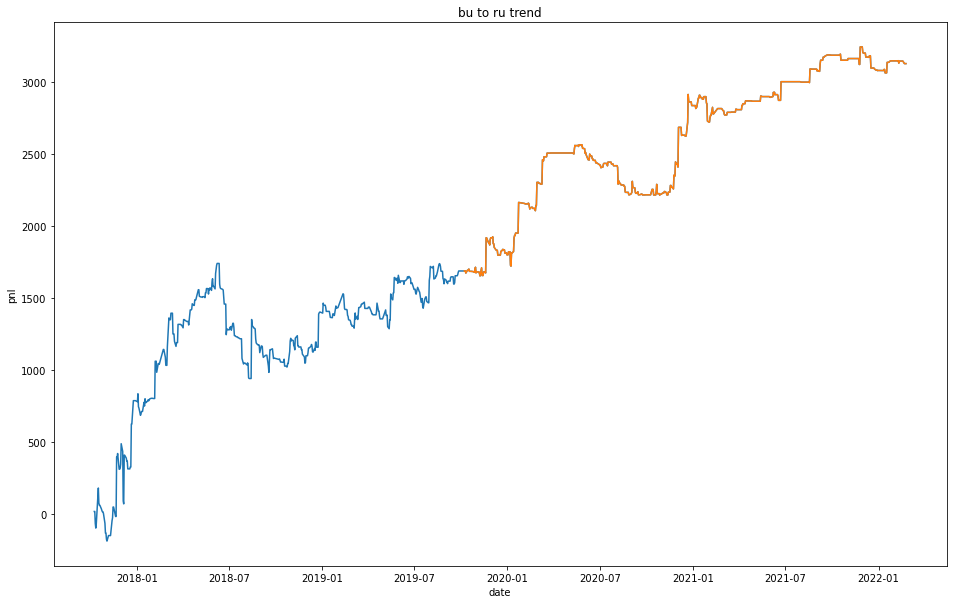

In [30]:
train_stat =result["trend.signal.stat"]["train.stat"]
spread = product_info[product_y]["spread"]
good_strat = (train_stat["final.result"]["avg.pnl"]>2*spread) & (train_stat["final.result"]["num"]>0)
train_pnl = train_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
test_stat =result["trend.signal.stat"]["test.stat"]
test_pnl = test_stat["daily.pnl"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" to "+product_y+" trend");
plt.plot(format_dates, pnl.cumsum());
plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))
## 1.980213447040118 0.9902726069677059





- we can see that strategies in training set can still perform well in test set

In [31]:
from collections import OrderedDict
def get_arb_signal_pnl(file, product_x, product_y, signal_name, thre_mat, reverse=1, tranct_x=1.1e-4, tranct_y=1.1e-4, max_spread_x=1.1,
                       max_spread_y=1.1,tranct_ratio_x=True, tranct_ratio_y=True, HEAD_PATH="d:/intern", SAVE_PATH="e:/intern", rebate=0):
    ## load data
    data_x = load(HEAD_PATH+"/pkl tick/"+product_x+"/"+file)
    data_y = load(HEAD_PATH+"/pkl tick/"+product_y+"/"+file)
    [time_x, time_y] = load(HEAD_PATH+"/comb time/"+product_x+"_"+product_y+"/"+file)
    S_x = load(SAVE_PATH+"/tmp pkl/"+product_x+"/"+signal_name+"/"+file)
    S_y = load(SAVE_PATH+"/tmp pkl/"+product_y+"/"+signal_name+"/"+file)
    S = S_x[time_x] - S_y[time_y]    ## calculate the difference of signals               
    pred = S*reverse
    data_y = data_y[time_y].reset_index(drop=True)
    data_x = data_x[time_x].reset_index(drop=True)
    good_x = data_x["good"]
    good_y = data_y["good"]
    pred = pred[good_x & good_y]
    data_x = data_x[good_x & good_y].reset_index(drop=True)    
    data_y = data_y[good_x & good_y].reset_index(drop=True)
    result = pd.DataFrame(data=OrderedDict([("open", thre_mat["open"].values), ("close", thre_mat["close"].values),
                               ("num", 0), ("avg.pnl", 0), ("pnl", 0), ("avg.ret", 0), ("ret", 0)]), 
                          index=thre_mat.index)
    count = 0;
    cur_spread_x = data_x["ask"]-data_x["bid"]
    cur_spread_y = data_y["ask"]-data_y["bid"]
    for thre in thre_mat.iterrows():
        count = count+1
        buy = pred>thre[1]["open"]
        sell = pred<-thre[1]["open"]
        signal = pd.Series(data=0, index=data_x.index)
        position = signal.copy()
        signal[buy] = 1
        signal[sell] = -1
        scratch = -thre[1]["close"]
        position_pos = pd.Series(data=np.nan, index=data_x.index)
        position_pos.iloc[0] = 0
        position_pos[(signal==1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 1
        position_pos[(pred< -scratch) & (data_x["next.bid"]>0) & (data_y["next.ask"]>0) & (cur_spread_x<max_spread_x) &
                    (cur_spread_y<max_spread_y)] = 0
        position_pos.ffill(inplace=True)
        pre_pos = position_pos.shift(1)
        notional_position_pos_x = pd.Series(data=0, index=data_x.index)
        notional_position_pos_y = pd.Series(data=0, index=data_y.index)
        notional_position_pos_y[position_pos==1] = 1
        notional_position_pos_y[(position_pos==1) & (pre_pos==1)] = np.nan
        notional_position_pos_x[(notional_position_pos_x==1)] = 1/data_x["next.ask"][(notional_position_pos_x==1)]
        notional_position_pos_y[(notional_position_pos_y==1)] = -1/data_y["next.bid"][(notional_position_pos_y==1)]
        notional_position_pos_x.ffill(inplace=True)
        notional_position_pos_y.ffill(inplace=True)
        position_neg = pd.Series(data=np.nan, index=data_x.index)
        position_neg.iloc[0] = 0
        position_neg[(signal==-1) & (data_x["next.ask"]>0) & (data_x["next.bid"]>0) & (cur_spread_x<max_spread_x) &
                    (data_y["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = -1
        position_neg[(pred> scratch) & (data_x["next.ask"]>0) & (data_y["next.bid"]>0) & (cur_spread_y<max_spread_y)] = 0
        position_neg.ffill(inplace=True)
        pre_neg = position_neg.shift(1)
        notional_position_neg_x = pd.Series(data=0, index=data_x.index)
        notional_position_neg_y = pd.Series(data=0, index=data_y.index)
        notional_position_neg_y[position_neg==-1] = -1
        notional_position_neg_y[(position_neg==-1) & (pre_neg==-1)] = np.nan
        notional_position_neg_x[(notional_position_neg_x==-1)] = -1/data_x["next.bid"][(notional_position_neg_x==-1)]
        notional_position_neg_y[(notional_position_neg_y==-1)] = 1/data_y["next.ask"][(notional_position_neg_y==-1)]
        notional_position_neg_x.ffill(inplace=True)
        notional_position_neg_y.ffill(inplace=True)
        position = position_pos + position_neg
        notional_position_x = notional_position_pos_x+notional_position_neg_x
        notional_position_y = notional_position_pos_y+notional_position_neg_y
        #position[n_bar-1] = 0
        position.iloc[0] = 0
        position.iloc[-10:] = 0
        notional_position_x.iloc[0] = 0
        notional_position_y.iloc[0] = 0
        notional_position_x.iloc[-10:] = 0
        notional_position_y.iloc[-10:] = 0
        notional_change_pos_x = notional_position_x-notional_position_x.shift(1)
        notional_change_pos_y = notional_position_y-notional_position_y.shift(1)
        change_pos = position - position.shift(1)
        change_pos.iloc[0] = 0
        change_base = pd.Series(data=0, index=data_x.index)
        notional_change_pos_x.iloc[0] = 0
        notional_change_pos_y.iloc[0] = 0
        change_base_x = pd.Series(data=0, index=data_x.index)
        change_base_y = pd.Series(data=0, index=data_y.index)
        
        change_buy = change_pos>0
        change_sell = change_pos<0
        if tranct_ratio_x:
            change_base[change_buy] = change_base[change_buy]+data_x["next.ask"][change_buy]*(1+tranct_x)
            change_base[change_sell] = change_base[change_sell]+data_x["next.bid"][change_sell]*(1-tranct_x)
            change_base_x[change_buy] = data_x["next.ask"][change_buy]*(1+tranct_x)
            change_base_x[change_sell] = data_x["next.bid"][change_sell]*(1-tranct_x)
        else:
            change_base[change_buy] = change_base[change_buy]+data_x["next.ask"][change_buy]+tranct_x
            change_base[change_sell] = change_base[change_sell]+data_x["next.bid"][change_sell]-tranct_x
            change_base_x[change_buy] = data_x["next.ask"][change_buy]+tranct_x
            change_base_x[change_sell] = data_x["next.bid"][change_sell]-tranct_x
        if tranct_ratio_y:
            change_base[change_buy] = change_base[change_buy]-data_y["next.bid"][change_buy]*(1-tranct_y)
            change_base[change_sell] = change_base[change_sell]-data_y["next.ask"][change_sell]*(1+tranct_y)
            change_base_y[change_buy] = data_y["next.bid"][change_buy]*(1-tranct_y)
            change_base_y[change_sell] = data_y["next.ask"][change_sell]*(1+tranct_y)
        else:
            change_base[change_buy] = change_base[change_buy]-data_y["next.bid"][change_buy]+tranct_y
            change_base[change_sell] = change_base[change_sell]-data_y["next.ask"][change_sell]-tranct_y
            change_base_y[change_buy] = data_y["next.bid"][change_buy]-tranct_y
            change_base_y[change_sell] = data_y["next.ask"][change_sell]+tranct_y
            
        final_pnl = -sum(change_base*change_pos)
        ret = -sum(change_base_x*notional_change_pos_x)-sum(change_base_y*notional_change_pos_y)
        num = sum((position!=0) & (change_pos!=0))
        if num == 0:
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (0,0,0,0,0)
            return result
        else:
            avg_pnl = np.divide(final_pnl, num)
            avg_ret = np.divide(ret,num)
            result.loc[thre[0], ("num", "avg.pnl", "pnl", "avg.ret", "ret")] = (num, avg_pnl, final_pnl, avg_ret,ret)
    return result


In [32]:
signal_name = "total.trade.imb.4096" 
product_x = "bu"
product_y = "ru"
all_signal = load(SAVE_PATH+"/all signal/"+product_x+"_"+product_y+"."+signal_name+".pkl")
thre_list = []
open_list = np.arange(0.2,0.4,0.02)
for cartesian in itertools.product(open_list, np.array([0.2, 0.4, 0.6, 0.8, 1.0])):
        thre_list.append((cartesian[0], -cartesian[0] * cartesian[1]))
thre_list = np.array(thre_list)
thre_mat = pd.DataFrame(data=OrderedDict([("open", thre_list[:, 0]), ("close", thre_list[:, 1])]))

In [33]:
%%time
tranct_x = product_info[product_x]["tranct"]
tranct_y = product_info[product_y]["tranct"]
spread_x = product_info[product_x]["spread"]
spread_y = product_info[product_y]["spread"]
tranct_ratio_x = product_info[product_x]["tranct.ratio"]
tranct_ratio_y = product_info[product_y]["tranct.ratio"]
train_result = parLapply(CORE_NUM, all_dates[train_sample], get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="total.trade.imb.4096",
                  thre_mat=thre_mat, reverse=-1, tranct_x=tranct_x, tranct_y=tranct_y, max_spread_x=spread_x*1.1, max_spread_y=spread_y*1.1,
                         tranct_ratio_x=tranct_ratio_x, tranct_ratio_y=tranct_ratio_y)
test_result = parLapply(CORE_NUM, all_dates[test_sample], get_arb_signal_pnl, product_x=product_x, product_y=product_y, signal_name="total.trade.imb.4096",
                  thre_mat=thre_mat, reverse=-1, tranct_x=tranct_x, tranct_y=tranct_y, max_spread_x=spread_x*1.1, max_spread_y=spread_y*1.1,
                         tranct_ratio_x=tranct_ratio_x, tranct_ratio_y=tranct_ratio_y)
# Wall time: 12min 2s

Wall time: 2min 25s


In [34]:
save(train_result, "d:/intern/train.energy.arb.pkl")
save(test_result, "d:/intern/train.energy.arb.pkl")

In [35]:
train_stat = get_hft_summary(train_result, thre_mat,sum(train_sample))
good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
sum(good_strat)

34

In [36]:
train_stat["final.result"][good_strat]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
16,0.26,-0.104,122,11.767636,1435.65159,0.872053,273.68637,549.53924,0.001264,0.154152,1.088074,0.025729,0.051668,2.612464,2.983489
17,0.26,-0.156,120,15.020762,1802.49144,1.018377,273.68637,606.72200,0.001473,0.176759,1.191813,0.025729,0.056467,2.970869,3.130317
18,0.26,-0.208,120,20.104335,2412.52022,1.280854,273.68637,560.25589,0.001935,0.232245,1.435359,0.025729,0.046870,4.306104,4.955073
19,0.26,-0.260,120,19.962793,2395.53518,1.258943,273.68637,549.25551,0.001913,0.229525,1.410647,0.025729,0.046431,4.361422,4.943401
20,0.28,-0.056,91,21.767337,1980.82764,1.248872,266.83237,347.61729,0.001980,0.180218,1.354106,0.026145,0.026990,5.698300,6.677248
21,0.28,-0.112,90,23.786846,2140.81617,1.303407,293.68743,454.18582,0.002194,0.197433,1.430666,0.027492,0.031577,4.713525,6.252398
22,0.28,-0.168,90,28.775803,2589.82231,1.448454,293.68743,469.05011,0.002470,0.222277,1.519212,0.027492,0.033610,5.521419,6.613476
23,0.28,-0.224,90,33.831557,3044.84009,1.626702,293.68743,470.05099,0.002993,0.269390,1.697089,0.027492,0.033223,6.477680,8.108494
24,0.28,-0.280,90,34.665077,3119.85689,1.657083,293.68743,470.05099,0.003019,0.271687,1.712575,0.027492,0.033223,6.637273,8.177621
25,0.30,-0.060,59,18.518544,1092.59407,0.818495,0.00000,369.09506,0.001843,0.108746,0.948401,0.000000,0.028980,2.960197,3.752516


- we can see that there are no good strategies for a-m arbitrage
- the reason may be that oil contracts have too low volatility and intraday trading cannot cover transaction cost


In [37]:
test_stat = get_hft_summary(test_result, thre_mat,sum(test_sample))

In [38]:
test_stat["final.result"][good_strat]

,open,close,num,avg.pnl,total.pnl,sharpe,drawdown,max.drawdown,avg.ret,total.ret,sharpe.ret,drawdown.ret,max.drawdown.ret,mar,mar.ret
16,0.26,-0.104,16,-35.528604,-568.45767,-0.528521,649.71657,789.32992,-0.003561,-0.056974,-0.508396,0.063051,0.076275,-0.720178,-0.746952
17,0.26,-0.156,16,-32.403971,-518.46353,-0.478476,649.71657,789.32992,-0.003298,-0.052760,-0.469411,0.063051,0.076275,-0.656840,-0.691707
18,0.26,-0.208,16,-37.653524,-602.45638,-0.561033,656.63406,796.24741,-0.003669,-0.058703,-0.524040,0.063051,0.076275,-0.756620,-0.769614
19,0.26,-0.260,16,-37.653524,-602.45638,-0.561033,656.63406,796.24741,-0.003669,-0.058703,-0.524040,0.063051,0.076275,-0.756620,-0.769614
20,0.28,-0.056,12,-20.158986,-241.90783,-0.236800,544.71400,686.32756,-0.002496,-0.029956,-0.276136,0.056510,0.069735,-0.352467,-0.429571
21,0.28,-0.112,12,-26.409012,-316.90814,-0.298248,583.71378,725.32734,-0.003046,-0.036547,-0.329431,0.058552,0.071776,-0.436917,-0.509173
22,0.28,-0.168,12,-27.909169,-334.91003,-0.314941,583.71378,725.32734,-0.003046,-0.036547,-0.329431,0.058552,0.071776,-0.461736,-0.509173
23,0.28,-0.224,12,-27.909169,-334.91003,-0.314941,583.71378,725.32734,-0.003046,-0.036547,-0.329431,0.058552,0.071776,-0.461736,-0.509173
24,0.28,-0.280,12,-27.909169,-334.91003,-0.314941,583.71378,725.32734,-0.003046,-0.036547,-0.329431,0.058552,0.071776,-0.461736,-0.509173
25,0.30,-0.060,6,-72.258087,-433.54852,-0.438904,508.92423,673.36729,-0.007586,-0.045514,-0.429300,0.051908,0.067997,-0.643851,-0.669350


1.4432909936786504 -0.44481868600123603


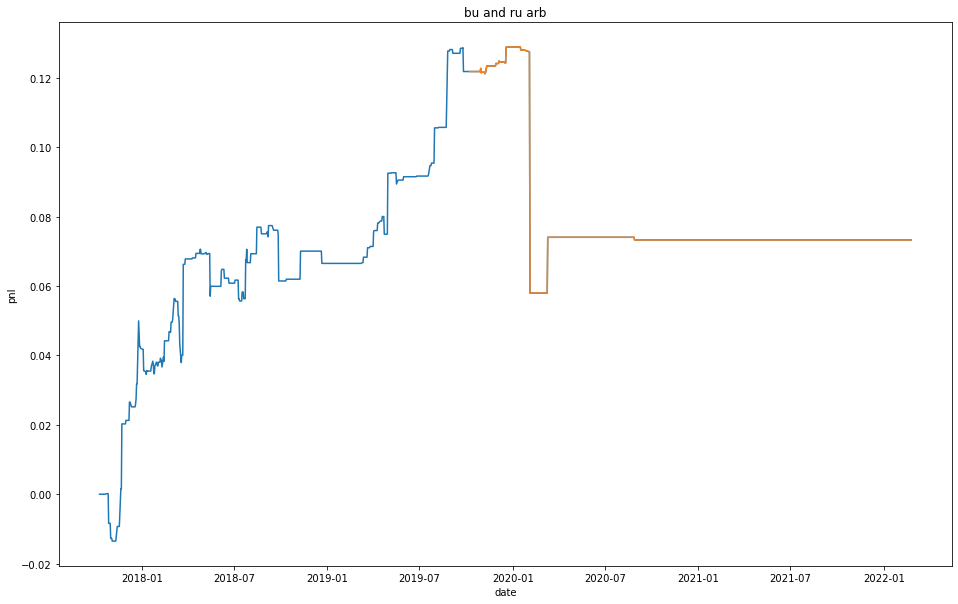

In [41]:
date_str = [n[0:8] for n in all_dates]
format_dates = (np.array([pd.to_datetime(d) for d in date_str]))
format_dates.sort();
train_sample = all_dates<split_date
test_sample = all_dates>split_date
spread = product_info[product_y]["spread"]
good_strat = (train_stat["final.result"]["avg.ret"]>0.001) & (train_stat["final.result"]["num"]>0)
train_pnl = train_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
test_pnl = test_stat["daily.ret"].loc[:, good_strat].sum(axis=1)/sum(good_strat)
pnl = np.append(train_pnl, test_pnl)
plt.figure(1, figsize=(16, 10));
plt.title("");
plt.xlabel("date");
plt.ylabel("pnl");
plt.title(product_x+" and "+product_y+" arb");
plt.plot(format_dates, pnl.cumsum());
plt.plot(format_dates[test_sample], pnl.cumsum()[test_sample])
print(sharpe(train_pnl), sharpe(test_pnl))

# 1.4432909936786504 -0.44481868600123603
